# Jigsaw puzzle
According to the [GWHD paper](https://arxiv.org/pdf/2005.02162.pdf) the images were split into 1024x1024 squared patches containing roughly 20 to 60 heads with only a few heads crossing the edges.
![gwhd_1](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F864684%2F9068f7f8dd526caa3657407c477e418f%2Fgwhd_splits.jpg?generation=1589069353753211&alt=media)

In this notebook you can find a raw code to solve this jigsaw puzzle.

## How it works
- From all of the images, it saves the left, right, top, and bottom edges. (1x2 has only left-right edges)
- In all possible combinations, it calculates a cosine distance (simple brute force algorithm)
- In the case of 1x2, it saves the top n matches.
- In the case of 2x2, it calculates a distance-sum on all possible (and valid) combination
- Store the top n matches
- Note: It generates only for one source per run. You have to modify the `TARGET` config (see below) and re-run everything.

## Limitations:
- The images from the `arvalis_3` source have very similar edges (mostly brown dirt), and this script won't work. (If you have any idea how to solve this, please leave me a comment)
- The `arvalis_1` and the `rres_1` sources have 2x3 patches (see the image above), this code is not working with 2x3 patches yet
- There are a few issues with the bounding boxes around edges. Ideally, we should merge the split boxes.

## Notations:
- **cX** columns in the generated files mean cell-X (for example 2x2: c1=top left, c2=bottom left, c3=top-right, c4=bottom-right). The values in theses columns are the original image id-s.

## TODO:
- 2x3 solution
- Merging the split boxes
- Create box dataframe with the same format we already have
- Fixing `arvalis_3` bug
- Create a dataset


In [82]:
import pandas as pd
import numpy as np
import cv2
import os
import ast
import hashlib
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine
%matplotlib inline

# Do not modify these!
TARGETS = ['arvalis_1', 'arvalis_2', 'arvalis_3', 'inrae_1', 'usask_1', 'rres_1', 'ethz_1']
N_PATCH = [(2, 3), (2, 2), (2, 2), (2, 2), (1, 2), (2, 3), (1, 2)] # 4 and 6 have 1 raw
THRESHOLDS = [0.0, 0.22, 0.0, 0.1, 0.12, 0.0, 0.12]
N_FULL_SIZE_IMAGES = [239, 51, 152, 44, 100, 72, 375]

In [83]:
# ======================================
# Set these values for your environment
# ======================================
DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_INPUT = "../data"

DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

# Target source index (see above: TARGETS)
# Currently working: [1, *2, 3, 4, 6]
# *Image similarity issue with arvalis_3 (idx: 2)
TARGET = 1

# On Kaggle the script won't save images
IS_KAGGLE_ENV = True

DIR_TARGET_ROOT = '../data/jigsaws/'
os.makedirs(DIR_TARGET_ROOT, exist_ok = True)

In [84]:
train_df = pd.read_csv(f"{DIR_INPUT}/train.csv")
train_df = pd.read_csv(f"{DIR_INPUT}/fixed_train.csv")

train_df = train_df[train_df['source'] == TARGETS[TARGET]]
train_df.reset_index(drop=True, inplace=True)

image_ids = train_df['image_id'].unique()
len(image_ids)

# From Andrew's kernel
train_df[['x', 'y', 'w', 'h']] = pd.DataFrame(
    np.stack(train_df['bbox'].apply(lambda x: ast.literal_eval(x)))).astype(np.float32)
train_df['x1'] = train_df['x'] + train_df['w']
train_df['y1'] = train_df['y'] + train_df['h']

train_df.head()

image_id  width  height                          bbox     source      x  \
0  3b4f7ba0a   1024    1024    [953.0, 820.0, 71.0, 72.0]  arvalis_2  953.0   
1  3b4f7ba0a   1024    1024  [583.0, 573.0, 110.0, 120.0]  arvalis_2  583.0   
2  3b4f7ba0a   1024    1024    [938.0, 790.0, 86.0, 68.0]  arvalis_2  938.0   
3  3b4f7ba0a   1024    1024  [335.0, 775.0, 115.0, 105.0]  arvalis_2  335.0   
4  3b4f7ba0a   1024    1024  [770.0, 568.0, 100.0, 118.0]  arvalis_2  770.0   

       y      w      h      x1     y1  
0  820.0   71.0   72.0  1024.0  892.0  
1  573.0  110.0  120.0   693.0  693.0  
2  790.0   86.0   68.0  1024.0  858.0  
3  775.0  115.0  105.0   450.0  880.0  
4  568.0  100.0  118.0   870.0  686.0

In [85]:
image_ids.shape

(204,)

## Calculate edge similarity

In [86]:
te = []  # top edges
be = []  # bottom edges
le = []  # left edges
re = []  # right edges

ids = [] # image ids

res_rl = [] # Results right-left
res_bt = [] # Results bottom-top

for image_id in image_ids:
    image = cv2.imread(DIR_TRAIN + '/{}.jpg'.format(image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # get pixels for right/left image egdes
    le.append(image[:, :1, :].flatten() / 255.0)
    re.append(image[:, -1:, :].flatten() / 255.0)
    # number of patch-rows
    #if N_PATCH[TARGET][0] > 1:
    te.append(image[:1, :, :].flatten() / 255.0)
    be.append(image[-1:, :, :].flatten() / 255.0)
    ids.append(image_id)

In [87]:
# left-right edge distances
for i, r in enumerate(re):
    for j, l in enumerate(le):
        # exclude the same image
        if i == j:
            continue
        res_rl.append({
            'right_edge': i,
            'left_edge': j,
            'cd': cosine(r, l)
        })            

In [88]:
# number of patch-rows
#if N_PATCH[TARGET][0] > 1:
# bottom-top edge distances
for i, b in enumerate(be):
    for j, t in enumerate(te):
        # exclude the same image
        if i == j:
            continue
        res_bt.append({
            'bottom_edge': i,
            'top_edge': j,
            'cd': cosine(b, t)
        })

In [89]:
res_rl = pd.DataFrame(res_rl)
res_rl.sort_values(by='cd', inplace=True)
res_rl = res_rl[res_rl['cd'] < THRESHOLDS[TARGET]]
res_rl.head()
res_rl.describe()

right_edge    left_edge           cd
count  3166.000000  3166.000000  3166.000000
mean    106.850916    92.878080     0.196369
std      58.217172    55.858009     0.028419
min       1.000000     2.000000     0.029563
25%      68.000000    47.000000     0.190345
50%      93.000000    84.000000     0.203627
75%     163.000000   138.000000     0.212781
max     203.000000   203.000000     0.219996

In [90]:
# number of patch-rows
#if N_PATCH[TARGET][0] > 1:
res_bt = pd.DataFrame(res_bt)
res_bt.sort_values(by='cd', inplace=True)
res_bt = res_bt[res_bt['cd'] < THRESHOLDS[TARGET]]
res_bt.head()

bottom_edge  top_edge        cd
18869           92       194  0.032030
11321           55       157  0.032691
13769           67       169  0.035772
917              4       106  0.037071
6221            30       132  0.037409

## Calculate distance sum

In [92]:
def save_results(data, n):
    dist = pd.DataFrame(data)
    dist.sort_values(by='dist', inplace=True)
    # select top smallest distance
    #dist = dist.iloc[0:51]
    dist = dist.iloc[0:N_FULL_SIZE_IMAGES[TARGET]]
    dist.reset_index(drop=True, inplace=True)

    result = dist.copy()
    result.drop(columns=['dist'], inplace=True)
    result['image_id'] = ''

    for i, row in enumerate(dist.iterrows()):
        row = row[1]
        for c in range(n):
            result.loc[i, f'c{c+1}'] = ids[int(row[f'c{c+1}'])]
        # generate new image ids
        newid = hashlib.md5(f'full_image_{TARGETS[TARGET]}_{i}'.encode()).hexdigest()[:10]
        result.loc[i, 'image_id'] = newid
        
    result.to_csv(f'{DIR_TARGET_ROOT}/full_size_{TARGETS[TARGET]}.csv', index=False)
    
    return result

In [77]:
if N_PATCH[TARGET] == (1, 2):
    sum_dist = []    
    res_rl = res_rl.iloc[0:N_FULL_SIZE_IMAGES[TARGET]]
    res_rl.reset_index(drop=True, inplace=True)

    for i, row in res_rl.iterrows():
        sum_dist.append({
            'c1': row['right_edge'],
            'c2': row['left_edge'],
            'dist': row['cd']
        })        
    result = save_results(sum_dist, n = N_PATCH[TARGET][0] * N_PATCH[TARGET][1])

In [ ]:
if N_PATCH[TARGET] == (2, 2):
    sum_distance = []
    for i1, r1 in res_rl.iterrows():
        for i2, r2 in res_rl.iterrows():
            a = res_bt[(res_bt['bottom_edge'] == r1['right_edge']) & (res_bt['top_edge'] == r2['right_edge'])]
            if a.shape[0] == 0:
                continue
            b = res_bt[(res_bt['bottom_edge'] == r1['left_edge']) & (res_bt['top_edge'] == r2['left_edge'])]
            if b.shape[0] == 0:
                continue
                
            sum_distance.append({
                'c1': r1['right_edge'],
                'c2': r2['right_edge'],
                'c3': r1['left_edge'],
                'c4': r2['left_edge'],
                'dist': r1['cd'] + r2['cd'] + a['cd'].values[0] + b['cd'].values[0]
            })
    result = save_results(sum_distance, n = N_PATCH[TARGET][0] * N_PATCH[TARGET][1])   
else:
    raise NotImplementedError

In [ ]:
len(result)

## Saving results

In [ ]:
result.head()

In [ ]:
def load_image(img):
    image1 = cv2.imread(DIR_TRAIN + '/{}.jpg'.format(img))
    return cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

def save_image(img, image_id, folder):
    os.makedirs(folder, exist_ok=True)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"{folder}/{image_id}.jpg", img)

def show_image(image):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.set_axis_off()
    ax.imshow(image)    
    
def generate_full_image(patches, rows=2, cols=2):
    i = 0
    target = np.zeros((rows * 1024, cols * 1024, 3))

    for c in range(cols):
        for r in range(rows):
            im = load_image(patches[f'c{i+1}'])
            target[(1024*r):(1024*(r+1)), (1024*c):(1024*(c+1)), :] = im
            i += 1
    return target.astype(np.uint8)

In [ ]:
# save full images
for i, row in result.iterrows():
    image = generate_full_image(row, rows=N_PATCH[TARGET][0], cols=N_PATCH[TARGET][1])
    save_image(image, row['image_id'], f"{DIR_TARGET_ROOT}/{TARGETS[TARGET]}")

## Examples

In [ ]:
data = result.iloc[0]
image = generate_full_image(data, rows=N_PATCH[TARGET][0], cols=N_PATCH[TARGET][1])
show_image(image)

## Adjust the bounding boxes

In [ ]:
COLORS = [(220, 0, 0), (0, 0, 220), (0, 220, 128), (220, 128, 0), (0, 220, 0), (128, 0, 128)]
OFFSETS = [(0, 0), (0, 1024), (1024, 0), (1024, 1024)]

def show_full_image_with_boxes(data):
    boxes = {}
    image = generate_full_image(data, rows=N_PATCH[TARGET][0], cols=N_PATCH[TARGET][1])

    for c in range(N_PATCH[TARGET][0] * N_PATCH[TARGET][1]):
        # Boxes for cell #c
        df = train_df[train_df['image_id'] == data[f'c{c+1}']][['x', 'y', 'x1', 'y1']]

        df['x'] = df['x'] + OFFSETS[c][0]
        df['x1'] = df['x1'] + OFFSETS[c][0]
        df['y'] = df['y'] + OFFSETS[c][1]
        df['y1'] = df['y1'] + OFFSETS[c][1]

        boxes[f'c{c+1}'] = df

    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    i=0
    for c in range(N_PATCH[TARGET][1]):
        for r in range(N_PATCH[TARGET][0]):
            bboxes = boxes[f'c{i+1}'].values.astype(np.uint32)
            for box in bboxes:
                cv2.rectangle(image, (box[0], box[1]),
                              (box[2], box[3]), COLORS[i], 2)   
            i += 1        

    ax.set_axis_off()
    ax.imshow(image)

In [ ]:
def get_full_image_boxes(data, train_df):
    image_id = data['image_id']
    print(image_id)
    boxes = {}  
    boxes_df = pd.DataFrame()
    for c in range(N_PATCH[TARGET][0] * N_PATCH[TARGET][1]):
        # Boxes for cell #c
        df = train_df[train_df['image_id'] == data[f'c{c+1}']][['x', 'y', 'x1', 'y1']]
        df['x'] = df['x'] + OFFSETS[c][0]
        df['x1'] = df['x1'] + OFFSETS[c][0]
        df['y'] = df['y'] + OFFSETS[c][1]
        df['y1'] = df['y1'] + OFFSETS[c][1]        
        boxes[f'c{c+1}'] = df     
        boxes_df = pd.concat([boxes_df, df], ignore_index = True)
    boxes_df['image_id'] = data['image_id']  
    
    return boxes, boxes_df

In [ ]:
boxes, boxes_df = get_full_image_boxes(result.iloc[2], train_df)
len(result)

In [40]:
def combine_boxes(boxes_df):
    # combine boxes for a single image
    # for (2,2)
    x_pairs = boxes_df[(boxes_df['x1']==1024)|(boxes_df['x']==1024)]
    # for (1,2)
    y_pairs = boxes_df[(boxes_df['y1']==1024)|(boxes_df['y']==1024)]
    # for (2,3)
    #y_pairs2 = boxes_df['x','y','x1','y1'][(boxes_df['y1']==2048) & (boxes_df['y']==2048)]
    
    return x_pairs, y_pairs

In [41]:
x_pairs, y_pairs = combine_boxes(boxes_df)
y_pairs.head()

x       y      x1      y1    image_id
3    906.0   970.0  1000.0  1024.0  4fb23675b1
28   906.0  1024.0  1001.0  1063.0  4fb23675b1
77  1661.0  1024.0  1776.0  1105.0  4fb23675b1

In [42]:
x_pairs.head()

x       y      x1      y1    image_id
0   980.0   179.0  1024.0   281.0  4fb23675b1
9   885.0   770.0  1024.0   862.0  4fb23675b1
18  954.0   499.0  1024.0   614.0  4fb23675b1
25  975.0  1454.0  1024.0  1548.0  4fb23675b1
30  901.0  1730.0  1024.0  1820.0  4fb23675b1

In [43]:
boxes_df.head()

x      y      x1      y1    image_id
0  980.0  179.0  1024.0   281.0  4fb23675b1
1  115.0  283.0   226.0   386.0  4fb23675b1
2  934.0  611.0  1016.0   709.0  4fb23675b1
3  906.0  970.0  1000.0  1024.0  4fb23675b1
4  570.0   36.0   643.0   159.0  4fb23675b1

In [44]:
boxes_df.describe()

x            y           x1           y1
count    83.000000    83.000000    83.000000    83.000000
mean    980.686768   953.397583  1075.602417  1044.168701
std     590.083679   602.365417   595.689941   596.655334
min       2.000000     1.000000    53.000000    62.000000
25%     493.500000   366.500000   585.500000   508.000000
50%     934.000000  1024.000000  1024.000000  1063.000000
75%    1512.500000  1506.000000  1652.000000  1602.000000
max    1991.000000  1963.000000  2048.000000  2042.000000

In [45]:
# save full images boxes annotations
boxes_df = pd.DataFrame()
for i, row in result.iterrows():
    boxes, df = get_full_image_boxes(row, train_df)
    boxes_df = pd.concat([boxes_df, df], ignore_index = True)
boxes_df.to_csv(f"{DIR_TARGET_ROOT}/{TARGETS[TARGET]}_boxes.csv")

b8cacfe067
1e425ffd33
4fb23675b1
0d62cee82d
d865298c60
8171a416c7
ae0f709a3a
3ce12f3c5e
6bb6c940c5
0a48849842
bd3679e05b
8190f191b4
066dad5b68
987116bb03
2741036a50
2e7250e7d4
6608ec3658
16aec47717
c16658e89e
8a9fc697ef
06263692e6
622ab475f0
3f95ca3037
ebd3027cc7
2ed015a919
5909bac4e6
d4c98a59a9
4dd5bfb78c
cfd152a367
9894802e12
6ded75846f
a951bb42d7
489b2ad548
26c61337d5
32c0dc1910
dd1ded8b57
134bdcd3c9
1cb50ff6dc
4f4d952e50
2484b01fa9
dbf3d80771


In [46]:
len(boxes_df['image_id'].unique())

41

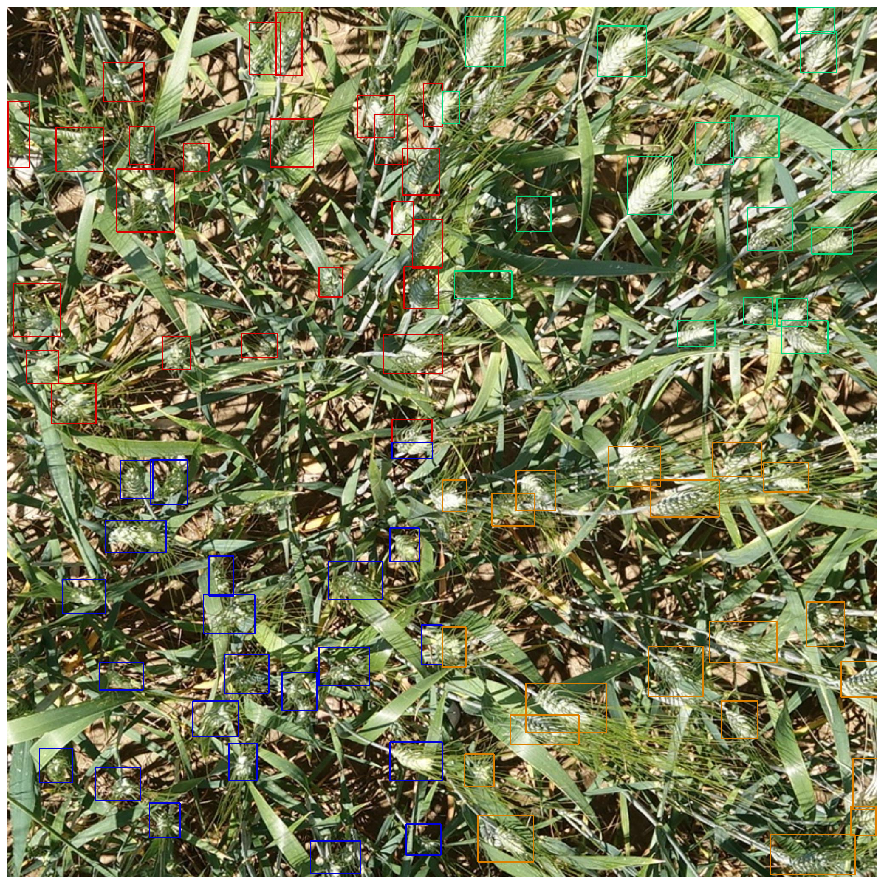

In [47]:
show_full_image_with_boxes(result.iloc[2])

In [48]:
boxes_df.head()

x      y      x1      y1    image_id
0  532.0  893.0   616.0  1000.0  b8cacfe067
1  913.0   79.0  1024.0   176.0  b8cacfe067
2  594.0  236.0   669.0   338.0  b8cacfe067
3  732.0  604.0   819.0   691.0  b8cacfe067
4  494.0  780.0   578.0   901.0  b8cacfe067

In [192]:
boxes_df.describe()

x            y           x1           y1
count  3427.000000  3427.000000  3427.000000  3427.000000
mean   1005.348145   946.706421  1103.970581  1037.731201
std     577.028931   594.701233   584.730103   592.325745
min       0.000000     0.000000    38.000000    40.000000
25%     571.500000   417.000000   663.000000   514.000000
50%    1024.000000   964.000000  1072.000000  1024.000000
75%    1497.000000  1459.000000  1605.000000  1550.500000
max    2017.000000  2022.000000  2048.000000  2048.000000

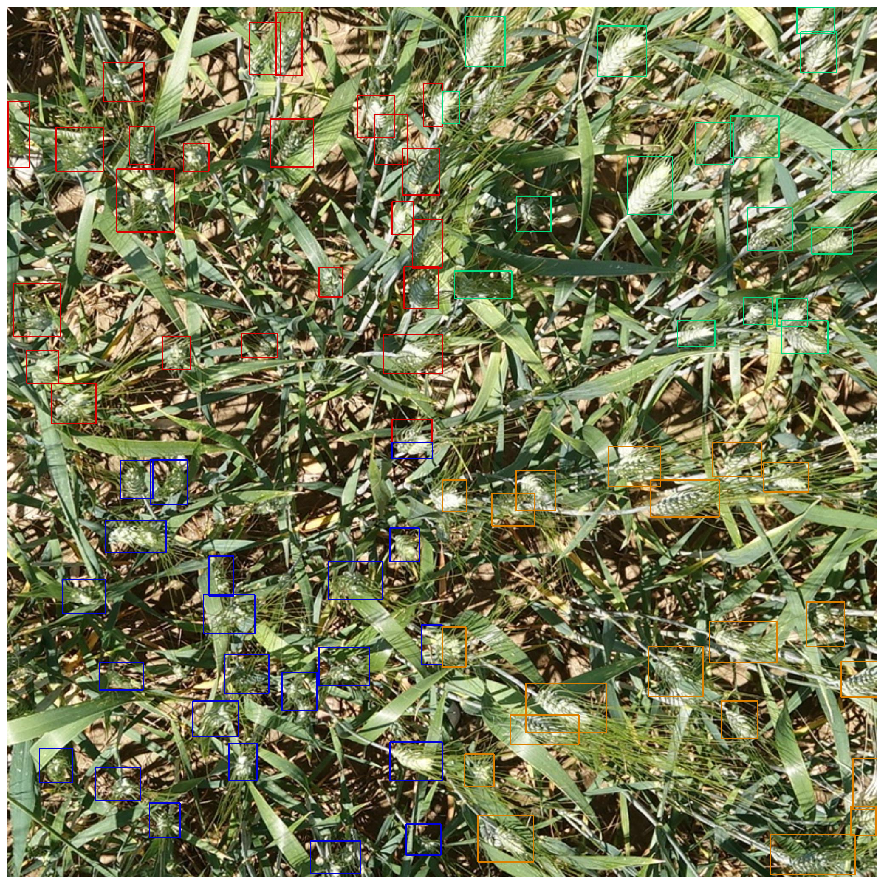

In [193]:
show_full_image_with_boxes(result.iloc[2])

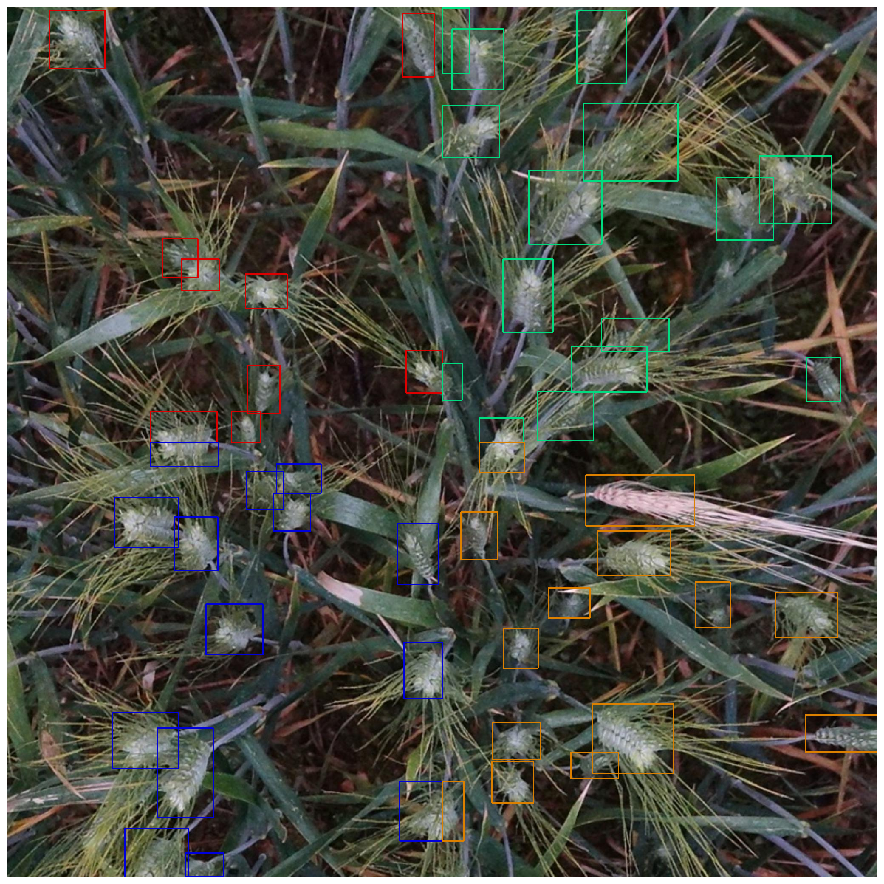

In [81]:
show_full_image_with_boxes(result.iloc[10])